# TODO
- Check weight distribution
  - Are worse subnets used at all?
  - Can we read something from the weights?
- Compare stacked results for different datasets
- Compare stacked results for different subnets

# Imports and Methods

In [ ]:
# !pip install tensorflow==2.13.0
# !pip install keras==2.13.1
from google.colab import drive

drive.mount("/content/drive")
MODEL_DIR = "drive/Othercomputers/My Computer/models"

In [1]:
MODEL_DIR = "models"

In [2]:
import itertools
import json
from copy import deepcopy
from enum import Enum, auto
from functools import partial
from glob import glob
from os import makedirs
from pathlib import Path
from typing import Any, Optional

import graphviz
import numpy as np
import pydot
import tensorflow as tf
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt
from sklearn.datasets import fetch_covtype, load_iris
from sklearn.model_selection import train_test_split
from tensorflow import keras, nn
from tensorflow.keras import callbacks, layers
from tensorflow.keras import utils as kutils
from tensorflow.keras.applications import (
    VGG19,
    InceptionV3,
    ResNet50,
    inception_v3,
    resnet,
    vgg19,
)
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.models import clone_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.saving import load_model

# DATA LOADERS


class FitMode(Enum):
    FORCE = auto()
    CONTINUE = auto()
    DEFAULT = auto()


def _common_sklearn_loader(data: dict) -> tuple[np.ndarray, np.ndarray]:
    return data["data"], kutils.to_categorical(data["target"])


def get_iris(**tts_kwargs) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    X, y = _common_sklearn_loader(load_iris())
    return train_test_split(X, y, **tts_kwargs)


def get_covtype(**tts_kwargs) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    X, y = _common_sklearn_loader(fetch_covtype())
    return train_test_split(X, y, **tts_kwargs)


def get_imagenette(prep_fn, im_size, imagenet_y: bool = False):
    def prep_y(y, imagenet):
        LABEL_NUMS = [0, 217, 482, 491, 497, 566, 569, 571, 574, 701]
        y, y_size = (tf.gather(LABEL_NUMS, y), 1000) if imagenet else (y, 10)
        return tf.one_hot(y, y_size)

    def prep_x(x, prep_fn, im_size):
        x = tf.image.resize(x, im_size)
        x = prep_fn(x)
        return x

    def map_fn(data, imagenet, prep_fn, im_size):
        return prep_x(data["image"], prep_fn, im_size), prep_y(data["label"], imagenet)

    ds = tfds.load("imagenette", data_dir=Path("data"))
    return [
        ds[ds_type].map(
            partial(map_fn, prep_fn=prep_fn, im_size=im_size, imagenet=imagenet_y)
        )
        for ds_type in ("train", "validation")
    ]


def prep_y(y, out_size):
    return tf.one_hot(y, out_size)


def prep_x(x, preprocess_function, im_size):
    x = tf.image.resize(x, im_size)
    x = preprocess_function(x)
    return x


def get_tf_dataset_stacked(
    dataset, out_size, prep_fn, im_sizes, batch_size, repeat_n, split_prcnt=None
):
    if split_prcnt is None:
        ds, ds_info = tfds.load(dataset, data_dir=Path("data"), with_info=True)
        splits = {k: v.num_examples for k, v in ds_info.splits.items()}
    else:
        (train, test), ds_info = tfds.load(
            dataset,
            data_dir=Path("data"),
            shuffle_files=False,
            split=[f"train[:{split_prcnt}%]", f"train[{split_prcnt}%:]"],
            with_info=True,
        )
        ds = {"train": train, "test": test}
        splits = {
            "train": ds_info.splits["train"].num_examples * split_prcnt / 100,
            "test": ds_info.splits["train"].num_examples * (1 - split_prcnt / 100),
        }

    print(splits)

    return [
        (
            (
                (x, y)
                for x, y in zip(
                    zip(
                        *[
                            ds[ds_type]
                            .map(lambda data: prep_x(data["image"], fn, size))
                            .repeat(repeat_n if ds_type == "train" else repeat_n + 1)
                            .batch(batch_size)
                            for fn, size in zip(prep_fn, im_sizes)
                        ]
                    ),
                    ds[ds_type]
                    .map(lambda data: prep_y(data["label"], out_size))
                    .repeat(repeat_n if ds_type == "train" else repeat_n + 1)
                    .batch(batch_size),
                )
            ),
            int(splits[ds_type] // batch_size),
        )
        if ds_type in ds
        else None
        for ds_type in ("train", "validation", "test")
    ]


# MODEL BUILDERS


def _model_formats(name: str) -> Path:
    return Path(MODEL_DIR) / f"{name}.keras", Path(MODEL_DIR) / f"{name}_history.json"


def model_save(name: str, model: keras.Model, history: dict):
    makedirs(MODEL_DIR, exist_ok=True)
    model_path, history_path = _model_formats(name)
    model.save(model_path)
    with history_path.open("w") as h:
        json.dump(history, h)


def model_load(name: str) -> tuple[Optional[keras.Model], Optional[dict]]:
    def __read_history(history_path: Path) -> dict:
        with history_path.open() as h:
            return json.load(h)

    model_path, history_path = _model_formats(name)
    return None if not model_path.is_file() else load_model(
        model_path
    ), None if not history_path.is_file() else __read_history(history_path)


def _make_dense_end(
    layer_sizes: list[int],
    base_layer: layers.Layer = None,
    dropout_rates: Optional[list[float]] = None,
) -> layers.Layer:
    if dropout_rates is None:
        dropout_rates = [None] * len(layer_sizes)
    for size, dropout_rate in zip(layer_sizes[:-1], dropout_rates[:-1]):
        if dropout_rate is not None:
            base_layer = layers.Dropout(dropout_rate)(base_layer)
        base_layer = layers.Dense(size, activation=nn.relu)(base_layer)
    if dropout_rates[-1] is not None:
        base_layer = layers.Dropout(dropout_rates[-1])(base_layer)
    return layers.Dense(layer_sizes[-1], activation=nn.softmax)(base_layer)


def define_stacked_model(
    models: list[keras.Model],
    cutout_layers: list[int],
    master_layer_sizes: list[int],
    **master_kwargs,
) -> keras.Model:
    for i, layer in [
        [i, layer] for i, model in enumerate(models) for layer in model.layers
    ]:
        layer.trainable = False
        layer._name = "stack_" + str(i + 1) + "_" + layer.name
    stacked_input = [model.input for model in models]
    stacked_output = [
        model.layers[cutout_layer].output
        for model, cutout_layer in zip(models, cutout_layers)
    ]
    merge = (
        Concatenate()(stacked_output) if len(stacked_output) > 1 else stacked_output[0]
    )
    output = _make_dense_end(master_layer_sizes, base_layer=merge, **master_kwargs)
    model = keras.Model(inputs=stacked_input, outputs=output)
    model.compile(
        loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    return model


def make_classic_dense(layer_sizes: list[int]) -> keras.Model:
    input = keras.Input(shape=(layer_sizes[0],))
    output = _make_dense_end(layer_sizes[1:], base_layer=input)
    model = keras.Model(inputs=input, outputs=output)
    model.compile(
        loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    return model


# MODEL FITTERS


def fit_model(
    name: str,
    model: keras.Model,
    data: Any,
    y: Optional[Any] = None,
    *,
    MODE: FitMode = FitMode.DEFAULT,
    **kwargs,
) -> tuple[keras.Model, dict]:
    print(f"Fitting {name} model.")
    if MODE is not FitMode.FORCE:
        model_l, history_l = model_load(name)
        if model_l is not None and history_l is not None:
            if MODE is FitMode.DEFAULT:
                return model_l, history_l
            if MODE is FitMode.CONTINUE:
                model = model_l
    history = (
        model.fit(data, **kwargs) if y is None else model.fit(data, y, **kwargs)
    ).history
    if MODE is not FitMode.FORCE and history_l is not None:
        for param in history_l:
            history_l[param].extend(history[param])
        history = history_l
    model_save(name, model, history)
    return model, history


def fit_multiple_dense(
    layer_sizes_list: list[list[int]],
    xtr,
    ytr,
    name_suffixes: list[str],
    MODE: FitMode = FitMode.DEFAULT,
    **fit_kwargs,
):
    models = []
    for sizes, suffix in zip(layer_sizes_list, name_suffixes):
        name = f"{suffix}_{'_'.join([str(size) for size in sizes])}"
        model, history = fit_model(
            name, make_classic_dense(sizes), xtr, ytr, MODE=MODE, **fit_kwargs
        )
        models.append([name, model, history])
    return models


# UTILS


def plot_acc(history, ax, types=["test", "train"], custom_label=None):
    if "train" in types:
        ax.plot(
            np.array(history["accuracy"]) * 100,
            label="train" if custom_label is None else custom_label,
        )
    if "test" in types:
        ax.plot(
            np.array(history["val_accuracy"]) * 100,
            label="test" if custom_label is None else custom_label,
        )
    ax.grid()
    ax.set_ylabel("Precyzja [%]")
    ax.set_xlabel("Epoki")
    ax.legend()
    return ax


def plot_loss(history, ax, types=["test", "train"], custom_label=None):
    if "train" in types:
        ax.plot(
            history["loss"], label="train" if custom_label is None else custom_label
        )
    if "test" in types:
        ax.plot(
            history["val_loss"], label="test" if custom_label is None else custom_label
        )
    ax.grid()
    ax.set_ylabel("Strata")
    ax.set_xlabel("Epoki")
    ax.legend()
    return ax


def plot_history(history: dict, sup_txt: str = ""):
    fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(10, 4))

    # fig.suptitle(f"Wyniki {sup_txt}")

    ax_loss = plot_loss(history, ax_loss)
    ax_acc = plot_acc(history, ax_acc)

    return fig, (ax_loss, ax_acc)


def list_models():
    for file in glob(str(Path(MODEL_DIR) / "*.json")):
        file = Path(file)
        with file.open() as f:
            data = json.load(f)
            print(
                file.name,
                f"epochs={len(data['loss'])}",
                f"best_acc={max(data['val_accuracy'])}",
            )

In [3]:
list_models()

covtype_54_108_216_54_8_history.json epochs=100 best_acc=0.9099678993225098
covtype_54_108_54_8_history.json epochs=100 best_acc=0.8412089347839355
covtype_54_27_8_history.json epochs=100 best_acc=0.7439653277397156
covtype_v01_54_108_216_54_8_history.json epochs=200 best_acc=0.9059404730796814
covtype_v02_54_108_216_54_8_history.json epochs=200 best_acc=0.9152861833572388
covtype_v03_54_108_216_54_8_history.json epochs=200 best_acc=0.9109317064285278
covtype_v04_54_108_216_54_8_history.json epochs=200 best_acc=0.9108026623725891
covtype_v05_54_108_216_54_8_history.json epochs=200 best_acc=0.9056048393249512
covtype_v06_54_108_216_54_8_history.json epochs=200 best_acc=0.9131261706352234
covtype_v07_54_108_216_54_8_history.json epochs=200 best_acc=0.9101916551589966
covtype_v08_54_108_216_54_8_history.json epochs=200 best_acc=0.9152861833572388
covtype_v09_54_108_216_54_8_history.json epochs=200 best_acc=0.9045807719230652
covtype_v10_54_108_216_54_8_history.json epochs=200 best_acc=0.9

# Experiments

## Basic Iris POC
Creating a basic stacked network trained to classify iris data which is built on subnets trained on the same data. The subnets and overnet have the following layers sizes:
```
subnet1: 4, 8, 3
subnet2: 4, 8, 8, 3
subnet3: 4, 8, 16, 8, 3
overnet: 10, 3
```
The subnets and the stacked net are deliberately trained on few epochs to ilustrate the gain of accuracy with stacking.

In [ ]:
xtr, xts, ytr, yts = get_iris(train_size=0.7, shuffle=True)
iris_models_data = fit_multiple_dense(
    [[4, 8, 3], [4, 8, 8, 3], [4, 8, 16, 8, 3]],
    xtr,
    ytr,
    validation_data=(xts, yts),
    name_suffixes=["iris"] * 3,
    epochs=25,
    batch_size=10,
    verbose=1,
)

In [ ]:
[plot_history(history, name)[0] for name, _, history in iris_models_data]

In [ ]:
iris_stacked_model = define_stacked_model(
    [model_data[1] for model_data in iris_models_data],
    [-2 for _ in iris_models_data],
    [10, 3],
)
iris_stacked_model, iris_stacked_history = fit_model(
    "stacked_iris",
    iris_stacked_model,
    [xtr] * len(iris_stacked_model.input),
    ytr,
    validation_data=([xts] * len(iris_stacked_model.input), yts),
    epochs=25,
    batch_size=10,
    verbose=1,
)

In [ ]:
kutils.plot_model(iris_stacked_model, show_shapes=True)

In [ ]:
plot_history(iris_stacked_history, "stacked_iris")

## Tests on covtype data

### Repeat of POC with covtype
Same as above but now the dataset is considerably more difficult so we don't have to artificially lower the amount of epochs. The layers of subnets and overnet are as follows:
```
subnet1: 54, 27, 8
subnet2: 54, 108, 54, 8
subnet3: 54, 108, 216, 54, 8
overnet: 270, 135, 8
```

In [ ]:
xtr, xts, ytr, yts = get_covtype(train_size=0.8, shuffle=True)

In [ ]:
covtype_models_data = fit_multiple_dense(
    [[54, 27, 8], [54, 108, 54, 8], [54, 108, 216, 54, 8]],
    xtr,
    ytr,
    validation_data=(xts, yts),
    name_suffixes=["covtype"] * 3,
    epochs=100,
    batch_size=256,
    verbose=1,
)

In [ ]:
for i, fig in enumerate(
    [
        plot_history(history, name)[0]
        for name, (_, _, history) in zip(
            ["podsieci 1", "podsieci 2", "podsieci 3"], covtype_models_data
        )
    ]
):
    fig.savefig(f"podsiec{i+1}.png")

In [ ]:
tl_covtype_models_data = []
for i, mod in enumerate(covtype_models_data):
    covtype_stacked_model = define_stacked_model(
        [mod[1]],
        [-2],
        [270, 135, 8],
    )
    tl_covtype_models_data.append(
        fit_model(
            f"transfer_covtype_{i+1}",
            covtype_stacked_model,
            [xtr],
            ytr,
            validation_data=([xts], yts),
            epochs=100,
            batch_size=256,
            verbose=1,
        )
    )

covtype_stacked_model = define_stacked_model(
    [model_data[1] for model_data in covtype_models_data],
    [-2 for _ in covtype_models_data],
    [270, 135, 8],
)
covtype_stacked_model, covtype_stacked_history = fit_model(
    "stacked_covtype",
    covtype_stacked_model,
    [xtr] * len(covtype_stacked_model.input),
    ytr,
    validation_data=([xts] * len(covtype_stacked_model.input), yts),
    epochs=100,
    batch_size=256,
    verbose=1,
)

In [ ]:
kutils.plot_model(covtype_stacked_model, show_shapes=True)

In [ ]:
for i, (his, mod) in enumerate(tl_covtype_models_data):
    fig, _ = plot_history(his, "sieci budowanej przez łączenie")
    fig.savefig(f"tl_covtype_{i+1}.png")
fig, _ = plot_history(covtype_stacked_history, "sieci budowanej przez łączenie")
fig.savefig("snn_covtype.png")

### Several same shaped subnets
This test runs stacked nets based on a given number of identical subnets. The aim was to see how increase in accuracy depends on the number of subnets.

In [ ]:
same_submodels = fit_multiple_dense(
    [[54, 108, 216, 54, 8]] * 10,
    xtr,
    ytr,
    name_suffixes=[f"covtype_v{i:02d}" for i in range(1, 15)],
    validation_data=(xts, yts),
    epochs=200,
    batch_size=256,
    verbose=1,
)

same_stacked_models = []
for submodel_count in range(2, 15):
    print(f"Same submodels: {submodel_count}")
    same_stacked_model = define_stacked_model(
        [model_data[1] for model_data in same_submodels[:submodel_count]],
        [-2 for _ in same_submodels[:submodel_count]],
        [54 * (submodel_count + 1), 27 * (submodel_count + 1), 8],
    )
    same_stacked_model, same_stacked_history = fit_model(
        f"stacked_covtype_same_n{submodel_count:02d}",
        same_stacked_model,
        [xtr] * len(same_stacked_model.input),
        ytr,
        validation_data=([xts] * len(same_stacked_model.input), yts),
        epochs=200,
        batch_size=256,
        verbose=1,
    )
    same_stacked_models.append(
        [
            f"stacked_covtype_same_n{submodel_count:02d}",
            same_stacked_model,
            same_stacked_history,
        ]
    )

identical_submodels = [model_load("covtype_v01_54_108_216_54_8")[0] for _ in range(15)]
identical_stacked_models = []
for submodel_count in range(2, 15):
    print(f"Identical submodels: {submodel_count}")
    identical_stacked_model = define_stacked_model(
        [model_data for model_data in identical_submodels[:submodel_count]],
        [-2 for _ in identical_submodels[:submodel_count]],
        [54 * (submodel_count + 1), 27 * (submodel_count + 1), 8],
    )
    identical_stacked_model, identical_stacked_history = fit_model(
        f"stacked_covtype_identical_n{submodel_count:02d}",
        identical_stacked_model,
        [xtr] * len(identical_stacked_model.input),
        ytr,
        validation_data=([xts] * len(identical_stacked_model.input), yts),
        epochs=200,
        batch_size=256,
        verbose=1,
    )
    identical_stacked_models.append(
        [
            f"stacked_covtype_identical_n{submodel_count:02d}",
            identical_stacked_model,
            identical_stacked_history,
        ]
    )

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
for name, _, history in same_stacked_models:
    plot_acc(history, ax, types=["test"], custom_label=name)

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
for name, _, history in identical_stacked_models:
    plot_acc(history, ax, types=["test"], custom_label=name)

## Tests on imported SOTA models
The following tests will use SOTA subnets pretrained on the imagenet dataset. They will be used in different combinations, configurations and for different applications.

### Compare regular net to transfer learned
This test takes the VGG19 net and tests it on the imagenette dataset which is a subset of imagenet containing only 10 classes. Two configurations are tested in order:
- Evaluation of the net as is
- Evaluation of the net but transferlearned on imagenette

In [ ]:
vgg19_model = VGG19()
imgnette_train, imgnette_val = get_imagenette(
    vgg19.preprocess_input, (224, 224), imagenet_y=True
)
vgg19_model.compile(
    loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
)
vgg19_model.evaluate(imgnette_val.batch(32), verbose=1)

In [ ]:
imnet_train, imnet_val = get_imagenette(vgg19.preprocess_input, (224, 224))
vgg19_headless = VGG19()
tl_vgg19_model = define_stacked_model([vgg19_headless], [-2], [1024, 512, 10])
tl_vgg19_model.compile(
    loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
)
tl_vgg19_model, tl_vgg19_history = fit_model(
    "vgg19_imagenette",
    tl_vgg19_model,
    imnet_train.batch(64),
    validation_data=imnet_val.batch(64),
    epochs=10,
)
tl_vgg19_model.evaluate(imnet_val.batch(32), verbose=1)

### Stacked CIFAR100 Training

In [ ]:
(train, spe_train), _, (test, spe_test) = get_tf_dataset_stacked(
    dataset="cifar100",
    out_size=100,
    prep_fn=[
        vgg19.preprocess_input,
    ],
    im_sizes=[(224, 224)],
    batch_size=30,
    repeat_n=30,
)

stacked_model = define_stacked_model([VGG19()], [-3], [1024, 100], dropout_rate=0.2)
stacked_model.compile(
    loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
)
stacked_model, stacked_history = fit_model(
    "vgg19_cifar",
    stacked_model,
    train,
    validation_data=test,
    validation_steps=spe_test,
    epochs=30,
    steps_per_epoch=spe_train,
)
kutils.plot_model(stacked_model, show_shapes=True)
plot_history(stacked_history, "")

In [ ]:
(train, spe_train), _, (test, spe_test) = get_tf_dataset_stacked(
    dataset="cifar100",
    out_size=100,
    prep_fn=[
        inception_v3.preprocess_input,
    ],
    im_sizes=[(299, 299)],
    batch_size=120,
    repeat_n=30,
)

stacked_model = define_stacked_model(
    [InceptionV3()], [-2], [2048, 100], dropout_rates=[0.2, 0.5]
)
stacked_model.compile(
    loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
)
stacked_model, stacked_history = fit_model(
    "inceptionv3_cifar_D",
    stacked_model,
    train,
    validation_data=test,
    validation_steps=spe_test,
    epochs=30,
    steps_per_epoch=spe_train,
)
kutils.plot_model(stacked_model, show_shapes=True)
plot_history(stacked_history, "")

In [ ]:
(train, spe_train), _, (test, spe_test) = get_tf_dataset_stacked(
    dataset="cifar100",
    out_size=100,
    prep_fn=[
        resnet.preprocess_input,
    ],
    im_sizes=[(224, 224)],
    batch_size=120,
    repeat_n=30,
)

stacked_model = define_stacked_model(
    [ResNet50()], [-2], [2048, 100], dropout_rates=[0.2, 0.5]
)
stacked_model.compile(
    loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
)
stacked_model, stacked_history = fit_model(
    "resnet50_cifar_D",
    stacked_model,
    train,
    validation_data=test,
    validation_steps=spe_test,
    epochs=30,
    steps_per_epoch=spe_train,
)
kutils.plot_model(stacked_model, show_shapes=True)
plot_history(stacked_history, "")

In [ ]:
(train, spe_train), _, (test, spe_test) = get_tf_dataset_stacked(
    dataset="cifar100",
    out_size=100,
    prep_fn=[
        vgg19.preprocess_input,
        inception_v3.preprocess_input,
        resnet.preprocess_input,
    ],
    im_sizes=[(224, 224), (299, 299), (224, 224)],
    batch_size=120,
    repeat_n=30,
)

stacked_model = define_stacked_model(
    [VGG19(), InceptionV3(), ResNet50()], [-3, -2, -2], [4096, 100]
)
stacked_model.compile(
    loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
)
stacked_model, stacked_history = fit_model(
    "vgg19_inceptionv3_resnet50_cifar_A",
    stacked_model,
    train,
    validation_data=test,
    validation_steps=spe_test,
    epochs=30,
    steps_per_epoch=spe_train,
)
kutils.plot_model(stacked_model, show_shapes=True)
plot_history(stacked_history, "")

In [ ]:
(train, spe_train), _, (test, spe_test) = get_tf_dataset_stacked(
    dataset="cifar100",
    out_size=100,
    prep_fn=[
        vgg19.preprocess_input,
        inception_v3.preprocess_input,
        resnet.preprocess_input,
    ],
    im_sizes=[(224, 224), (299, 299), (224, 224)],
    batch_size=120,
    repeat_n=30,
)

stacked_model = define_stacked_model(
    [VGG19(), InceptionV3(), ResNet50()],
    [-3, -2, -2],
    [8192, 100],
    dropout_rates=[None, 0.5],
)
stacked_model.compile(
    loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
)
stacked_model, stacked_history = fit_model(
    "vgg19_inceptionv3_resnet50_cifar_C",
    stacked_model,
    train,
    validation_data=test,
    validation_steps=spe_test,
    epochs=30,
    steps_per_epoch=spe_train,
)
kutils.plot_model(stacked_model, show_shapes=True)
plot_history(stacked_history, "")

In [ ]:
fig, (tr_ax, ts_ax) = plt.subplots(1, 2, figsize=(16, 8))
for name in [
    "vgg19_cifar_A",
    "vgg19_cifar_B",
    "vgg19_cifar_C",
    "vgg19_cifar_D",
    "vgg19_cifar_E",
    "vgg19_cifar_F",
    "vgg19_cifar_G",
    "vgg19_cifar_H",
    "vgg19_cifar_I",
    "vgg19_cifar_J",
    "vgg19_cifar_K",
    "vgg19_cifar_L",
    "vgg19_cifar_M",
    "vgg19_cifar_N",
    "vgg19_cifar_O",
]:
    _, hist = model_load(name)
    plot_acc(hist, tr_ax, types=["train"], custom_label=name)
    plot_acc(hist, ts_ax, types=["test"], custom_label=name)

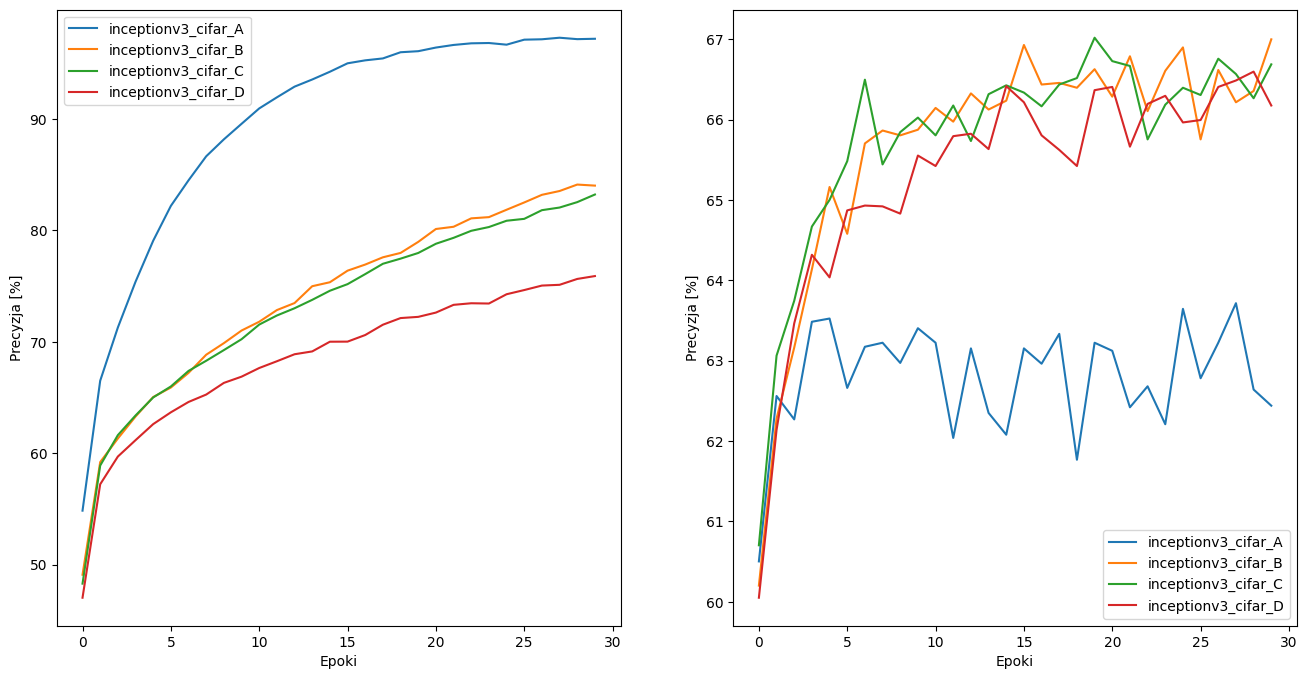

In [20]:
fig, (tr_ax, ts_ax) = plt.subplots(1, 2, figsize=(16, 8))
for name in [
    "inceptionv3_cifar_A",
    "inceptionv3_cifar_B",
    "inceptionv3_cifar_C",
    "inceptionv3_cifar_D",
]:
    _, hist = model_load(name)
    plot_acc(hist, tr_ax, types=["train"], custom_label=name)
    plot_acc(hist, ts_ax, types=["test"], custom_label=name)

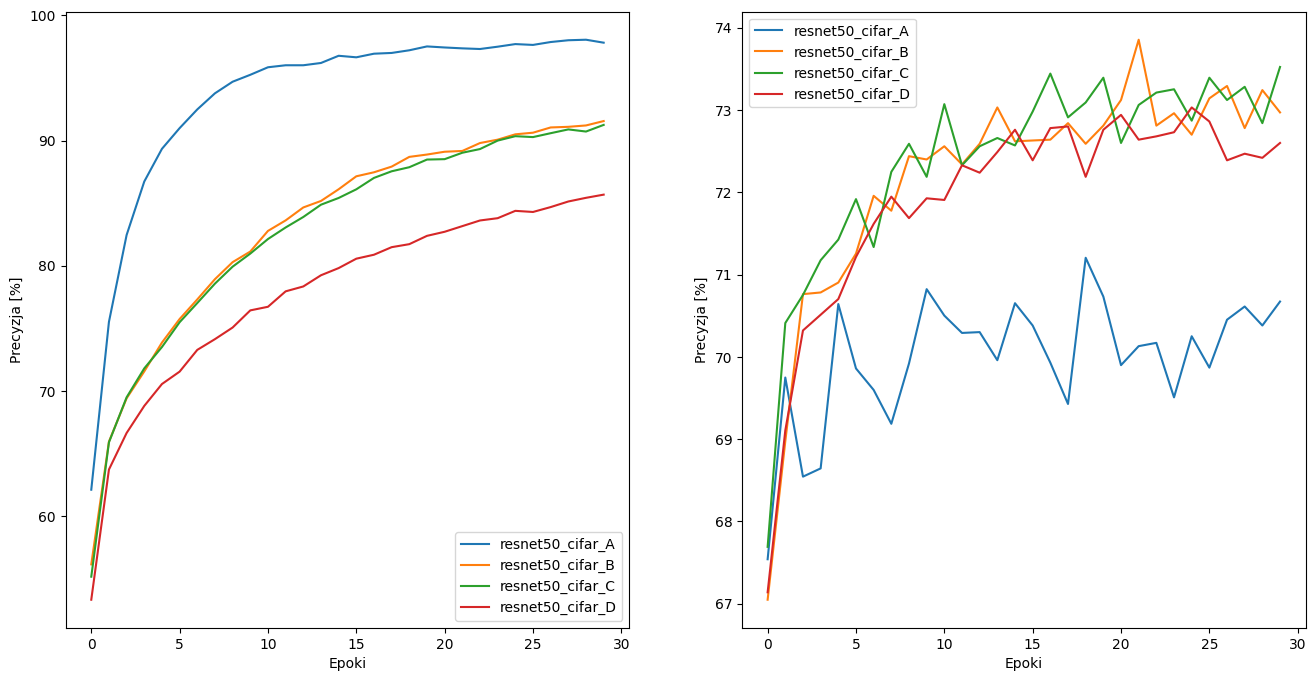

In [21]:
fig, (tr_ax, ts_ax) = plt.subplots(1, 2, figsize=(16, 8))
for name in [
    "resnet50_cifar_A",
    "resnet50_cifar_B",
    "resnet50_cifar_C",
    "resnet50_cifar_D",
]:
    _, hist = model_load(name)
    plot_acc(hist, tr_ax, types=["train"], custom_label=name)
    plot_acc(hist, ts_ax, types=["test"], custom_label=name)

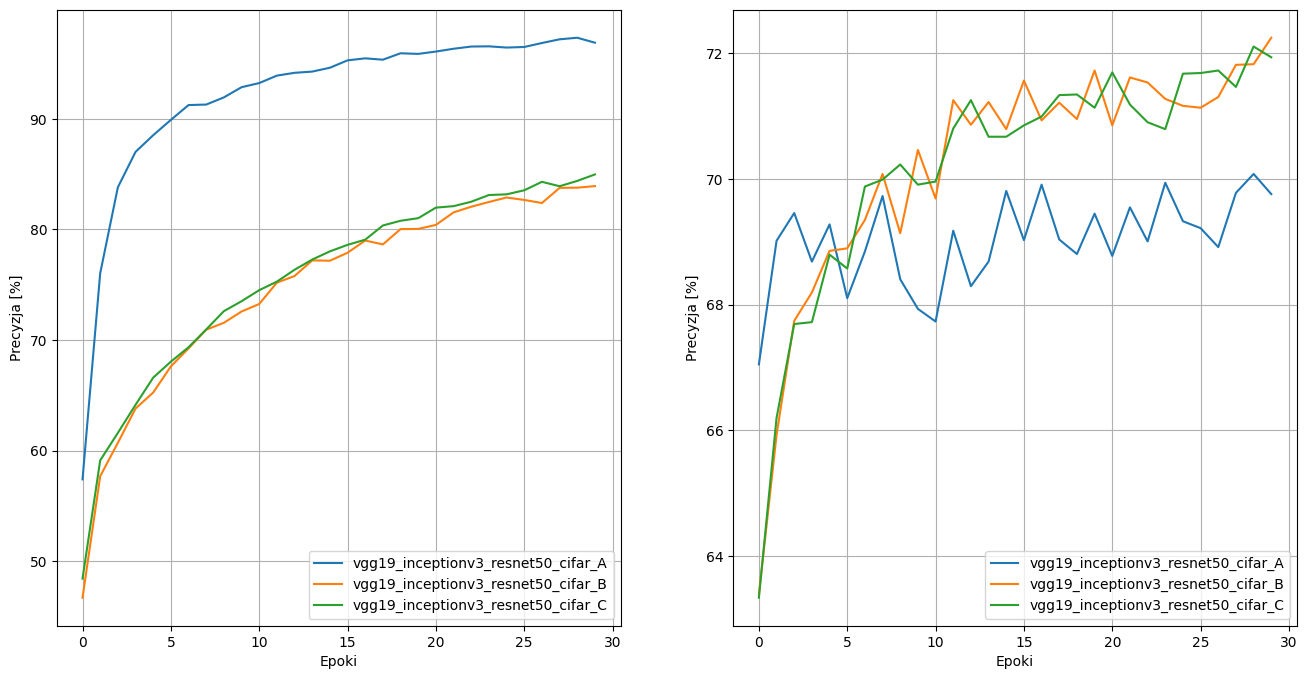

In [22]:
fig, (tr_ax, ts_ax) = plt.subplots(1, 2, figsize=(16, 8))
for name in [
    "vgg19_inceptionv3_resnet50_cifar_A",
    "vgg19_inceptionv3_resnet50_cifar_B",
    "vgg19_inceptionv3_resnet50_cifar_C",
]:
    _, hist = model_load(name)
    plot_acc(hist, tr_ax, types=["train"], custom_label=name)
    plot_acc(hist, ts_ax, types=["test"], custom_label=name)

In [ ]:
fig, (tr_ax, ts_ax) = plt.subplots(1, 2, figsize=(16, 8))
for name in [
    "vgg19_cifar_N",
    "inceptionv3_cifar_B",
    "resnet50_cifar_C",
    "vgg19_resnet50_cifar_A",
    "vgg19_inceptionv3_cifar_A_history",
    "vgg19_inceptionv3_resnet50_cifar_C",
]:
    _, hist = model_load(name)
    plot_acc(hist, tr_ax, types=["train"], custom_label=name)
    plot_acc(hist, ts_ax, types=["test"], custom_label=name)